In [1]:
import sys
import matplotlib.pyplot as plt

import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.nn import PyroSample, PyroModule
from pyro.infer import Trace_ELBO

sys.path.append("../sbo")

import sbo
import utilities

## Target function

In [2]:
class HyperbolicTarget(sbo.TargetFunction):
    
    def eval(self, x):
        
        x1 = x[...,0]
        x2 = x[...,1]

        return 0.3*x1**2 + 2*x2**2 - 20.0

target = HyperbolicTarget([[-10, 10], [-10, 10]])

## Training data

In [3]:
utilities.set_random_seed(112)

In [4]:
N_train_points = 2
X_train = torch.rand(N_train_points, 2)*20 + torch.FloatTensor([-10, -10])
y_train = target.eval(X_train)

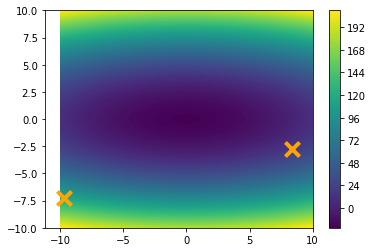

In [5]:
utilities.plot2d_func(target.eval, target.ranges)
plt.scatter(X_train[:,0].detach().numpy(), X_train[:,1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);

## Parametric model

In [6]:
class ParametricMeanFn(PyroModule):
    
    def __init__(self):
        super().__init__()
        self.alpha = PyroSample(dist.Uniform(0, 10))
        
    def forward(self, X):

        x1 = X[...,0]
        x2 = X[...,1]
        
        return self.alpha * x2**2

## SBO

In [7]:
pyro.clear_param_store()

# SBO parameters
sbo_steps = 10

opti_num_steps = 1000
opti_params = {"lr": 0.1}
optimizer = pyro.optim.Adam(opti_params)
loss = Trace_ELBO()

return_site = "EI"

# Acquisition function optimizer
acqf_optimizer = torch.optim.Adam
acqf_opti_num_steps = 100
acqf_opti_lr = 0.5

num_candidates = 10

# Sampling
num_samples = 5

In [8]:
# GP kernel
kernel = gp.kernels.Matern52(
    input_dim = X_train.shape[1], lengthscale = 10*torch.ones(X_train.shape[1]))

# Semi paramteric GP model
model = sbo.SemiParametricModel(X_train, y_train, ParametricMeanFn(), kernel)

# Defining GP's parameters
model.gp.kernel.lengthscale = PyroSample(dist.Uniform(0, 15).expand([X_train.shape[1]]).to_event())
model.gp.kernel.variance = PyroSample(dist.Uniform(0, 50))
model.gp.noise = PyroSample(dist.Uniform(0, 1))

guide = None

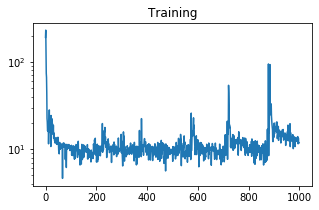

SBO step: 0 tensor([ 8.3597, -2.7253])


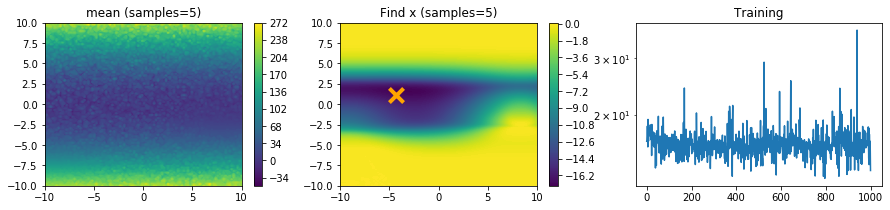

SBO step: 1 tensor([-4.3226,  1.0828])


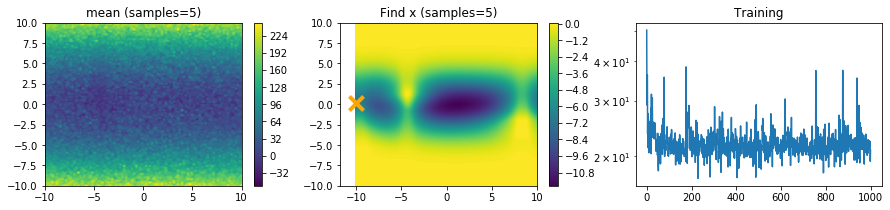

SBO step: 2 tensor([-9.9970,  0.1209])


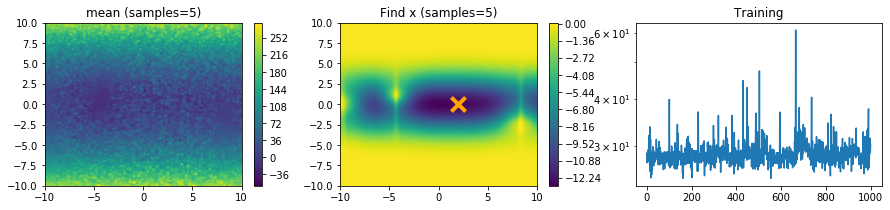

SBO step: 3 tensor([2.0027, 0.0682])


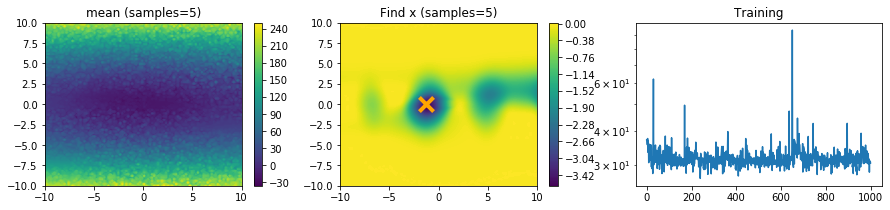

SBO step: 4 tensor([-1.2915,  0.0907])


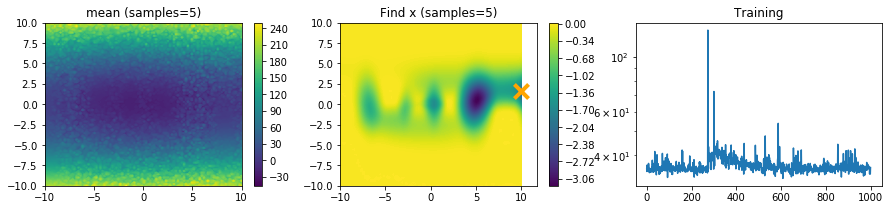

SBO step: 5 tensor([9.9992, 1.6431])


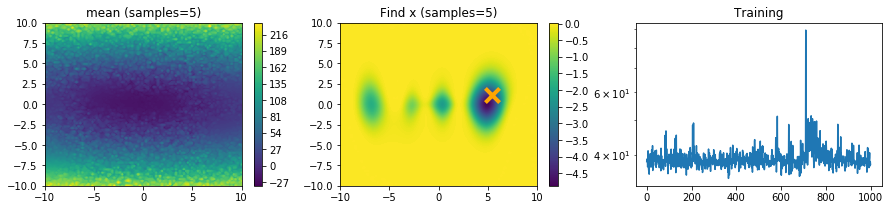

SBO step: 6 tensor([5.4068, 1.1504])


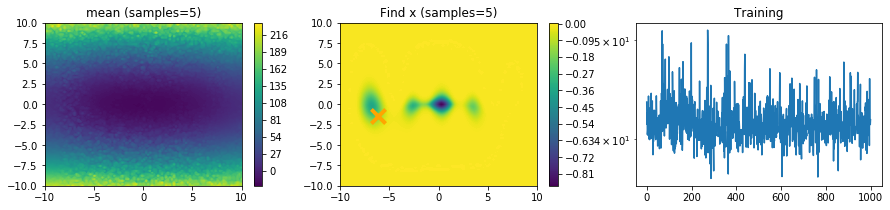

SBO step: 7 tensor([-6.1955, -1.5011])


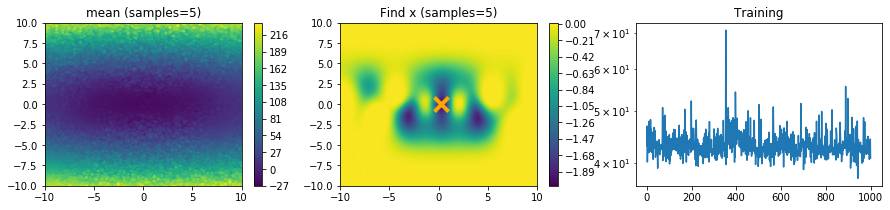

SBO step: 8 tensor([ 0.2625, -0.0174])


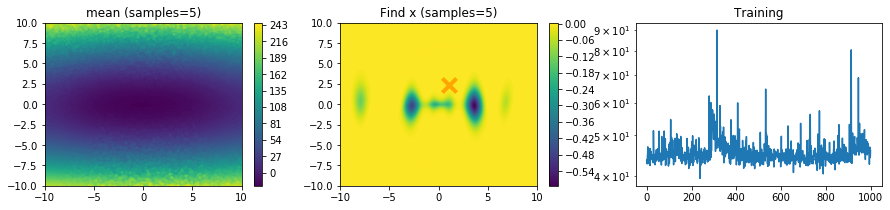

SBO step: 9 tensor([1.0171, 2.3192])


In [9]:
for i in range(sbo_steps):
    
    guide, predict, losses = sbo.step(model, guide, optimizer, loss, target, acqf_optimizer, 
                                      opti_num_steps=opti_num_steps, acqf_opti_num_steps=acqf_opti_num_steps,
                                      acqf_opti_lr=acqf_opti_lr, num_samples=num_samples, 
                                      num_candidates=num_candidates,
                                      return_site=return_site)
            
    ######################
    # Visualising the step
    ######################
    if i == 0:
        plt.figure(figsize=(5, 3))
        
        plt.title("Training")
        plt.semilogy(losses)
        
    else:
        plt.figure(figsize=(15, 3))
        
        plt.subplot(1,3,1)
        plt.title("mean (samples=%d)" % (num_samples))
        
        with torch.no_grad():
            utilities.plot2d_func(lambda x: predict(x)["y"].mean(0), target.ranges)
        
        plt.subplot(1,3,2)
        plt.title("Find x (samples=%d)" % (num_samples))
        
        with torch.no_grad():
            utilities.plot2d_func(lambda x: predict(x)[return_site].mean(0), target.ranges)
        
        plt.scatter(model.X[-1, 0].detach().numpy(), model.X[-1, 1].detach().numpy(), 
            marker="x", s=200, c='orange', zorder=2, linewidth=4);
        
        plt.subplot(1,3,3)
        plt.title("Training")
        plt.semilogy(losses)
    
    plt.show()
    
    print("SBO step: %d" % (i), model.X[-1])